# Sentiment analysis

### Setting up the envirionment

In [1]:
import json
import pandas as pd
import numpy as np
import urllib.request
import requests
import nltk
import re
import matplotlib.pyplot as plt
import math
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Setting up the functions

In [2]:
# read the sentiment data for a list of words 
df_sentiment = pd.read_csv("data/word_sentiment_data.txt", sep="\t")

# get english stopwords from the nltk library
stopwords = nltk.corpus.stopwords.words("english")

# define helper functions
sia = SentimentIntensityAnalyzer()

def fix_range(num,inMin = -1.0,inMax = 1.0,outMin = 0.0,outMax = 1.0):
    return outMin + (float(num - inMin) / float(inMax - inMin) * (outMax - outMin))

In [3]:
# custom sentiment function to calculate the sentiment based on the frequency distribution
def sentimentscore(text):
    text_tokenized = word_tokenize(text)
    fd = nltk.FreqDist([word.lower() for word in text_tokenized if word not in stopwords])
    
    found_words = 0
    score = 0

    for word in fd: 
        if word in df_sentiment.word.to_list():
            found_words += 1 * fd[word]
            hap_score = df_sentiment[df_sentiment.word == word]['happiness_average'].values[0] * fd[word]
            score += hap_score

    if (found_words == 0):
        return -1
    sentiment = score/found_words
    return sentiment

In [4]:
# NLTK's SentimentIntensityAnalyzer sentiment function
def sentimentscore_nltk(text):
    tokenized_text = word_tokenize(text)
    filtered_data = [word.lower() for word in tokenized_text if not word in stopwords]
    if len(filtered_data) == 0:
        return -1
    joint_filtered_text = (" ").join(filtered_data)
    sentiment = sia.polarity_scores(joint_filtered_text)
    return fix_range(sentiment['compound'])

In [5]:
# Set up characters dataframe
df = pd.read_csv("data/characters.csv")

### Characters' sentiment

In [6]:
# read characters history data
f = open("data/characters_history.json")
character_history = json.load(f)
f.close()

# read top characters data
f = open("data/top_characters.json")
top_characters = json.load(f)
f.close()

In [7]:
# calculate sentiment scores for all characters
sentiment_scores_nltk = {}
for key, value in character_history.items():
    if value != "":
        score_nltk = sentimentscore_nltk(value)
        score = sentimentscore(value)
        if score_nltk != -1 and score != -1:
            sentiment_scores_nltk[key] = (score_nltk, score)


In [8]:
# sort characters by their sentiment values
sentiment_scores_nltk = dict(sorted(sentiment_scores_nltk.items(), key=lambda item: item[1][0], reverse=True))
sentiment_scores = dict(sorted(sentiment_scores_nltk.items(), key=lambda item: item[1][1], reverse=True))

In [9]:
# print highest and lowest sentiment values (nltk)
print('nltk highest:',list(sentiment_scores_nltk.items())[0][0],list(sentiment_scores_nltk.items())[0][1][0],'nltk lowest:',list(sentiment_scores_nltk.items())[-1][0],list(sentiment_scores_nltk.items())[-1][1][0])

# print highest and lowest sentiment values (custom funtion)
print('custom highest:',list(sentiment_scores.items())[0][0],list(sentiment_scores.items())[0][1][1],'custom lowest:',list(sentiment_scores.items())[-1][0],list(sentiment_scores.items())[-1][1][1])

nltk highest: Teddy_Altman 0.99995 nltk lowest: Owen_Hunt 0.00019999999999997797
custom highest: Fran 6.235 custom lowest: Rebecca_Cohen 4.0520000000000005


In [10]:
# get top characters sentiment values
top_characters_sentiment_scores = {key: value for key,value in sentiment_scores_nltk.items() if key.replace("_", " ") in top_characters}

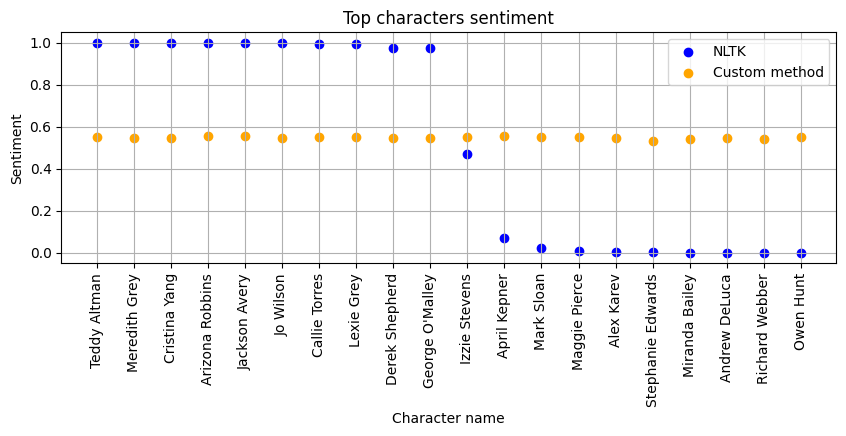

In [11]:
# plot top characters sentiment values
characters = [key.replace("_", " ") for key, val in top_characters_sentiment_scores.items()]
values_nltk = [val[0] for key, val in top_characters_sentiment_scores.items()]
values = [fix_range(val[1],inMin=0.0,inMax=10.0) for key, val in top_characters_sentiment_scores.items()]
plt.figure(figsize=(10,3))
plt.scatter(characters, values_nltk, color='blue')
plt.scatter(characters, values, color='orange')
plt.grid()
plt.xlabel("Character name")
plt.ylabel("Sentiment")
plt.title("Top characters sentiment")
plt.legend(['NLTK','Custom method'])
plt.xticks(rotation=90)

plt.show()

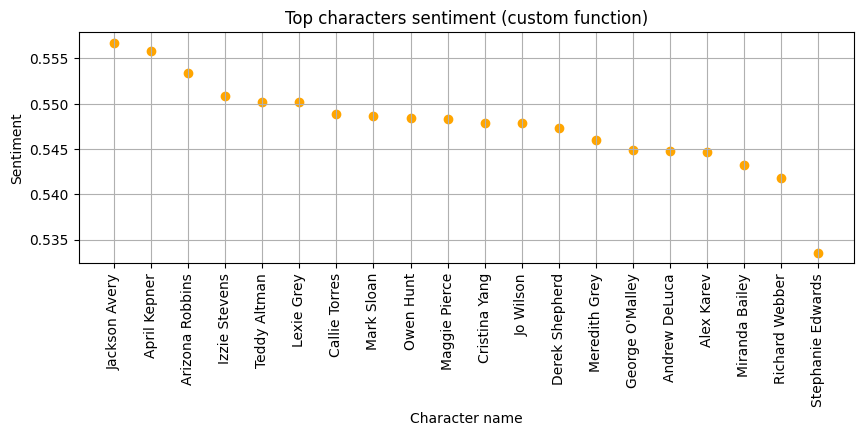

In [12]:
# plot top characters custom function sentiment values
customsorted_top_characters = dict(sorted(top_characters_sentiment_scores.items(), key=lambda item: item[1][1], reverse=True))

characters = [key.replace("_", " ") for key, val in customsorted_top_characters.items()]
values = [fix_range(val[1],inMin=0.0,inMax=10.0) for key, val in customsorted_top_characters.items()]
plt.figure(figsize=(10,3))
plt.scatter(characters, values, color='orange')
plt.grid()
plt.xlabel("Character name")
plt.ylabel("Sentiment")
plt.title("Top characters sentiment (custom function)")
plt.xticks(rotation=90)

plt.show()

### Seasons' and episodes' sentiment

In [13]:
# read episodes data
f = open("data/episodes.json")
seasons_data = json.load(f)
f.close()

In [14]:
# calculate sentiment for 1.each episode, 2. average of the episodes for each season and 3. season summary
for season in seasons_data:
    avg_season_sentiment = 0.0
    season_nr_of_episodes = 0
    for episode in season['episodes']:
        sentiment = sentimentscore(episode['summary'])
        episode['sentiment'] = sentiment
        if sentiment != -1:
            avg_season_sentiment = avg_season_sentiment + sentiment
            season_nr_of_episodes = season_nr_of_episodes + 1
    avg_season_sentiment = avg_season_sentiment/season_nr_of_episodes
    season_summary_sentiment = sentimentscore(season['summary_and_plots'])
    season['avg_sentiment'] = avg_season_sentiment
    season['summary_sentiment'] = season_summary_sentiment

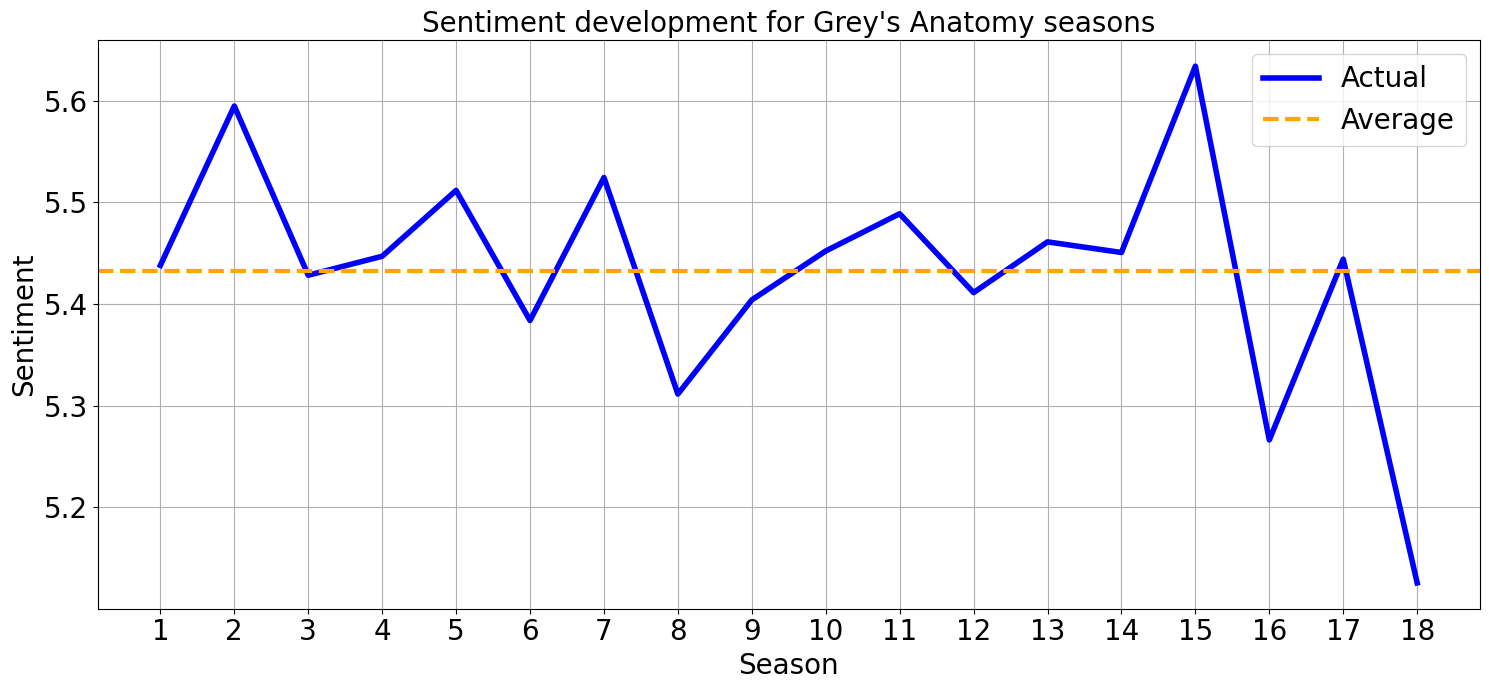

In [15]:
# get episode sentiment for each show
GA_data = list(filter(lambda season: season['show'] == "GA" and season['avg_sentiment'] != -1 and season['summary_sentiment'] != -1, seasons_data))
PP_data = list(filter(lambda season: season['show'] == "PP" and season['avg_sentiment'] != -1 and season['summary_sentiment'] != -1, seasons_data))
S19_data = list(filter(lambda season: season['show'] == "S19" and season['avg_sentiment'] != -1 and season['summary_sentiment'] != -1, seasons_data))

# plot the sentiment progression for Grey's Anatomy (season summaries' sentiment)
plt.figure(figsize=(15, 7))
sum_sentiments = [season['summary_sentiment'] for season in GA_data]
season_nr = [season['nr'] for season in GA_data]
plt.plot(season_nr, sum_sentiments, color="blue", linewidth=4)
plt.axhline(np.mean(sum_sentiments), linestyle="--", linewidth=3, color="orange")
plt.xticks(season_nr)

plt.xlabel("Season", fontsize=20)
plt.ylabel("Sentiment", fontsize=20)
plt.legend(['Actual','Average'], loc='upper right', fontsize=20)
plt.title("Sentiment development for Grey's Anatomy seasons", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

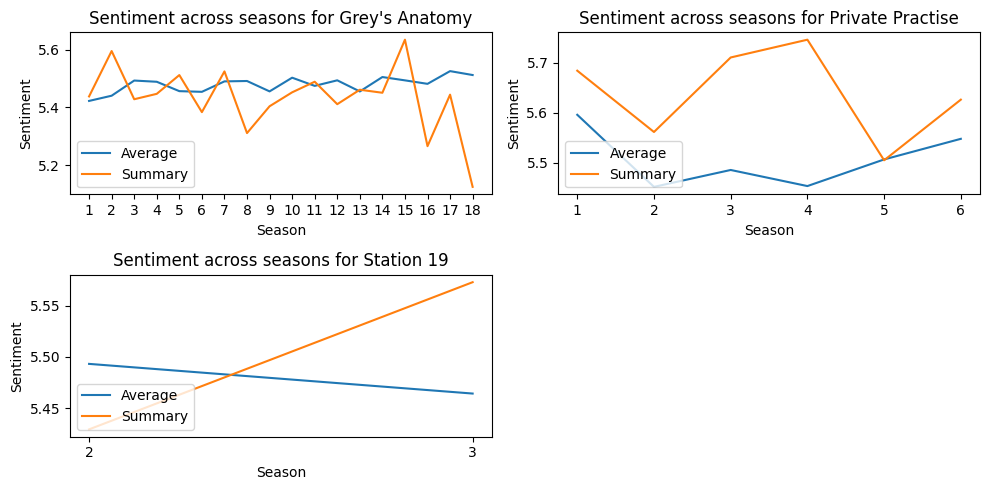

In [16]:
# plot the sentiment progression for all three shows (both season summaries' and average sentiment)
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
avg_sentiments = [season['avg_sentiment'] for season in GA_data]
sum_sentiments = [season['summary_sentiment'] for season in GA_data]
season_nr = [season['nr'] for season in GA_data]
plt.plot(season_nr, avg_sentiments)
plt.plot(season_nr, sum_sentiments)
plt.xticks(season_nr)
plt.xlabel("Season")
plt.ylabel("Sentiment")
plt.legend(['Average','Summary'], loc='lower left')
plt.title("Sentiment across seasons for Grey's Anatomy")

plt.subplot(2,2,2)
avg_sentiments = [season['avg_sentiment'] for season in PP_data]
sum_sentiments = [season['summary_sentiment'] for season in PP_data]
season_nr = [season['nr'] for season in PP_data]
plt.plot(season_nr, avg_sentiments)
plt.plot(season_nr, sum_sentiments)
plt.xticks(season_nr)
plt.xlabel("Season")
plt.ylabel("Sentiment")
plt.legend(['Average','Summary'], loc='lower left')
plt.title("Sentiment across seasons for Private Practise")

plt.subplot(2,2,3)
avg_sentiments = [season['avg_sentiment'] for season in S19_data]
sum_sentiments = [season['summary_sentiment'] for season in S19_data]
season_nr = [season['nr'] for season in S19_data]
plt.plot(season_nr, avg_sentiments)
plt.plot(season_nr, sum_sentiments)
plt.xticks(season_nr)
plt.xlabel("Season")
plt.ylabel("Sentiment")
plt.legend(['Average','Summary'], loc='lower left')
plt.title("Sentiment across seasons for Station 19")

plt.tight_layout()
plt.show()

In [17]:
# define color names for a plot
color_names = ['black','grey','lightcoral','brown','tomato','saddlebrown','bisque','orange','gold','olive','lawngreen','aqua','dodgerblue','navy','fuchsia','pink','mediumslateblue','teal']

In [18]:
# function to plot given show's episode sentiment for each season (subfigures)
def plot_seasons_sentiment(show_data):
    cols = 3
    rows = math.ceil(len(show_data)/cols)
    index = 1
    plt.figure(figsize=(cols*4,rows*2))
    for season in show_data:
        plt.subplot(rows,cols,index)
        sentiments = [episode['sentiment'] for episode in season['episodes']]
        episode_nr = [episode['nr'] for episode in season['episodes']]
        plt.plot(episode_nr, sentiments, color='blue')
        # min_sentiment = min(sentiments)
        plt.yticks([5.0,5.2,5.4,5.6,5.8])
        plt.xticks(episode_nr[::2])
        plt.ylabel("Sentiment")
        plt.xlabel("Episode nr")
        # min_sentiment_coordinate=episode_nr[sentiments.index(min_sentiment)]
        # plt.annotate('Lowest',color='purple', horizontalalignment='center', xy=(min_sentiment_coordinate,min_sentiment),xycoords=('data','axes pixels'), arrowprops=dict(color='purple'),xytext=(min_sentiment_coordinate,-50))
        plt.title("{} sentiment over time in season {}".format(season['show'], season['nr']))
        plt.grid()
        index = index + 1

    plt.tight_layout()
    plt.show()

# function to plot given show's episode sentiment for each season (scatter plot, one figure)
def plot_seasons_sentiment_in_one(show_data):
    plt.figure(figsize=(9,5))
    legend = []
    all_sentiments = []
    ci = 0
    for season in show_data:
        sentiments = [fix_range(episode['sentiment'],inMin=0.0,inMax=10.0) for episode in season['episodes']]
        episode_nr = [episode['nr'] for episode in season['episodes']]
        all_sentiments.extend(sentiments)
        plt.scatter(episode_nr, sentiments,color=color_names[ci])
        ci = ci + 1
        legend.append("Season "+str(season['nr']))
    mean = np.mean(all_sentiments)
    std = np.std(all_sentiments)
    print(mean,std)
    ticks = list(np.arange(0.50,0.57,0.01))
    plt.yticks(ticks)
    plt.xticks(range(0,27,2))
    plt.ylabel("Sentiment")
    plt.xlabel("Episode nr")
    plt.title("Sentiment over time in Grey's Anatomy seasons")
    plt.axhline(mean, color="red", linestyle='-', linewidth=2)
    plt.axhline(mean+std, color="orange", linestyle='--', linewidth=1)
    plt.axhline(mean-std, color="orange", linestyle='--', linewidth=1)
    plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

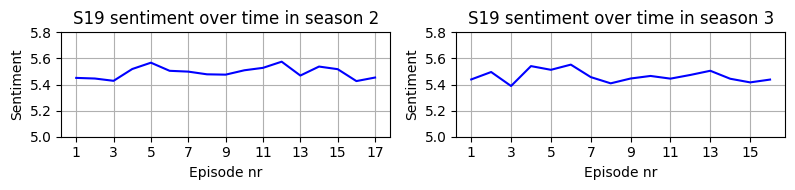

In [19]:
plot_seasons_sentiment(S19_data)

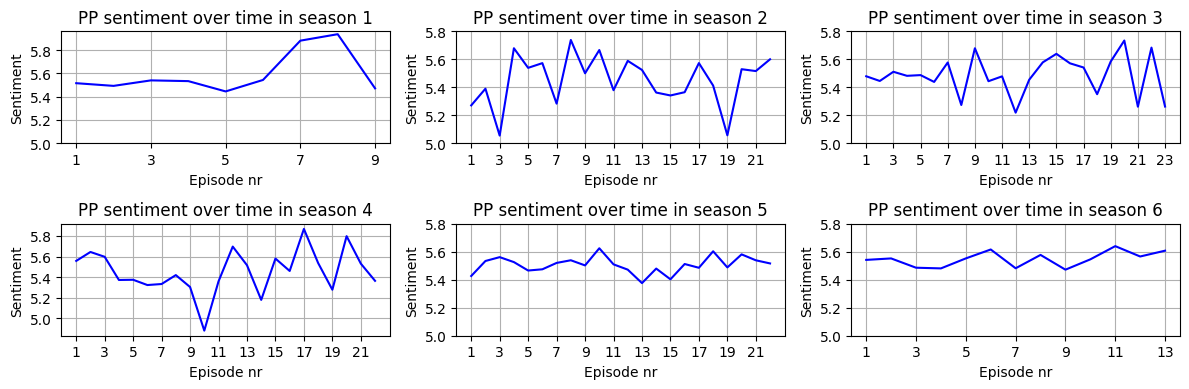

In [20]:
plot_seasons_sentiment(PP_data)

0.5480289690577569 0.006643148309977403


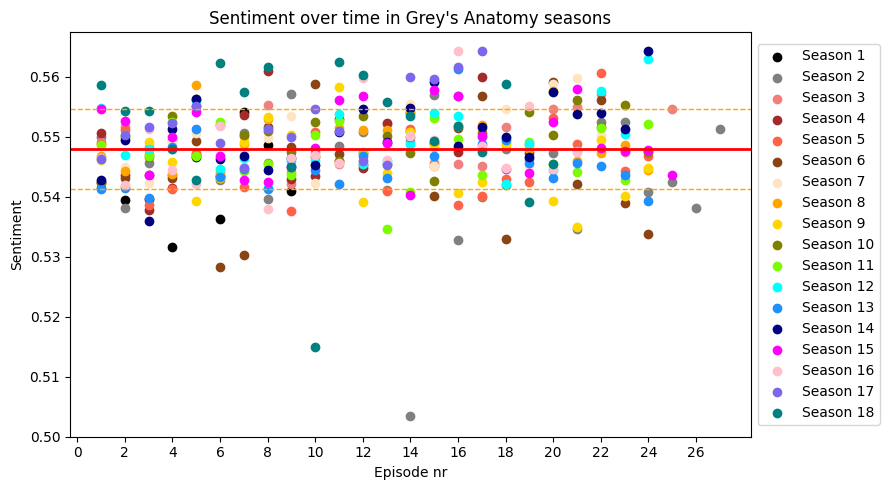

In [21]:
plot_seasons_sentiment_in_one(GA_data)

### Top characters' sentiment for season 8 of Grey's Anatomy (not used in the report)

In [22]:
# get episodes summary for GA season 8
GA_S8_data = GA_data[7]
character_occurences = {}

# count the occurences of each top character's name in each episode summary
for episode in GA_S8_data['episodes']:
    for character in top_characters:
        if character not in character_occurences:
            character_occurences[character] = []
        character_occurences[character].append(episode['summary'].count(character.split(' ')[0]))

# remove characters with 0 occurences
character_occurences = {key: val for key, val in character_occurences.items() if 0 not in val}

In [23]:
# calculate each top character's sentiment in season 8 by multiplying the occurences in the episode with the episode sentiment
# and normalizing it by the total number of occurences
character_sentiment_S8 = {key: [] for key, val in character_occurences.items()}
for key, val in character_occurences.items():
    for index in range(len(val)):
        character_sentiment_S8[key].append(fix_range(val[index],inMin=min(val),inMax=max(val)) * GA_S8_data['episodes'][index]['sentiment'])

# sum the values for each charater to get the total season happines
character_sentiment_S8 = {key: sum(val) for key, val in character_sentiment_S8.items()}


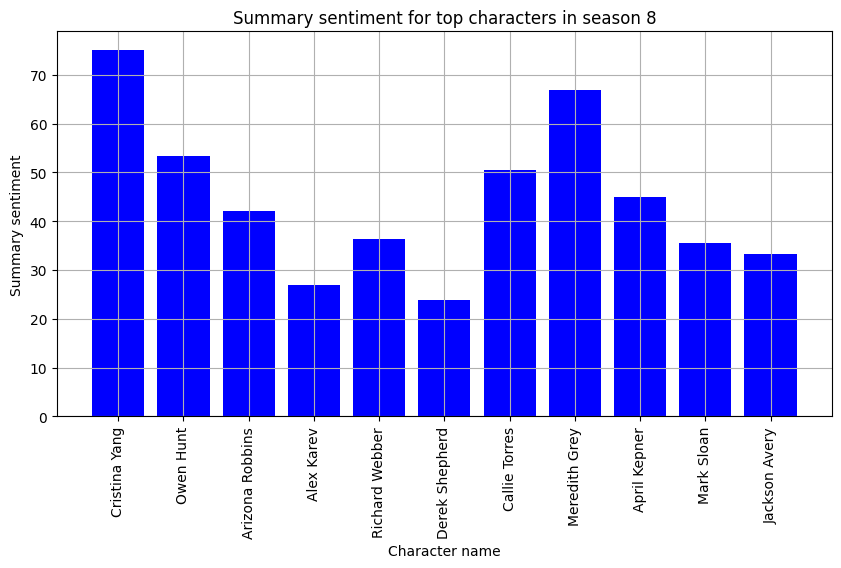

In [24]:
# plot the characters sentiment in season 8
characters = [key for key, val in character_sentiment_S8.items()]
values = [val for key, val in character_sentiment_S8.items()]
plt.figure(figsize=(10,5))
plt.bar(characters, values, color='blue')
plt.grid()
plt.title("Summary sentiment for top characters in season 8")
plt.ylabel("Summary sentiment")
plt.xlabel("Character name")
plt.xticks(rotation=90)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c50234c-0fc5-40eb-b0ef-2d1cda57d893' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>